# 𝔻𝕖𝕔𝕖𝕟𝕥ℕ𝕖𝕥: 𝕕𝕚𝕤-𝕖𝕟𝕥-𝕒𝕟𝕘𝕝𝕖𝕕 𝕟𝕖𝕥
Goal: create a neural network with disentangled early hidden layers. We want to analyse which textures contribute to the predictions.

In this notebook you can

1) train one or multiple DecentBlocks
  * we use a supervised contrastive loss function

2) train a DecentNet
  * we use the cross entropy loss
  * we freeze and use the DecentBlocks as part of the DecentNet
  * a fusion layer is the bridge between the DecentBlocks and the combined layers

3) Baseline

4) NOT HERE RIGHT NOW visualise the DecentBlocks and DecentNet (work in progress)
  * DeepDreams
  * Feature maps
  * Filters


8) BIMT with CONV
* use freeze, dropout and set channel to all zeros combination
* https://discuss.pytorch.org/t/freezing-part-of-the-layer-weights/9457/7

Todos:
* [ ] metrics / tensorboard


MIL: https://www.sciencedirect.com/science/article/pii/S0010482522004930

# Imports

In [1]:
# basics
import os
import sys
import time
import math
import random

# data
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from torchsummary import summary
from torchvision import transforms, datasets
from torchvision.models import shufflenet_v2_x1_0, resnet50


In [2]:
import sys
sys.path.insert(0, "helper")
from helper.dataset.transform.transform import ToTensor, ResizeCrop, RandomAugmentations, Normalise
from helper.dataset.transform.two_crop import *
from helper.compute.loss.supcon import SupConLoss
from helper.sampler.mixed_batch import MixedBatchSampler
#from helper.dataset.concept import ClusterConceptDataset, PosNegConceptDataset
from helper.model.decentblock import *


# metrics
from sklearn.metrics import f1_score

try:
    from torchvision.models import ShuffleNet_V2_X1_0_Weights
except:
    pass

# Experiment Configs

In [9]:
class Configs():

    def __init__(self):
        
        # general (half of these not in use)
        self.num_workers = 0
        self.epochs = 50
        self.n_samples_per_class_per_batch = 10

        # optimisation
        self.learning_rate = 0.01
        self.weight_decay = 1e-4
        self.momentum = 0.9

        # data - make sure it is the same size for quilted images
        self.image_size = 500

        self.prefix = "tmp"
        
        self.device = "cpu" # "cuda:0" if torch.cuda.is_available() else "cpu"
        
        # =============================================================================
        # Paths
        # =============================================================================
        
        # we read and write to an external directory!!
        self.base_path = r"C:/Users/Prinzessin/projects/decentnet"
        if not os.path.exists(self.base_path):
            os.makedirs(self.base_path)
        os.chdir(self.base_path) # this is now the main directory !!!!!!!!!!!!!!!!!!!!
        
        # input for decentblock
        self.csv_filenames =     [f"results/{self.prefix}/masks_info_label.csv"]
        self.concepts_path =     f"data/{self.prefix}/concepts"
        
        # input for decentnet
        self.train_path =        r"data/images/train"
        self.val_path =          r"data/images/val"
        self.test_path =         r"data/images/test"

        # output
        self.ckpt_net_path =     f"results/{self.prefix}/ckpts/decentnet"
        self.ckpt_blocks_path =  f"results/{self.prefix}/ckpts/decentblock"
        self.results_path =      f"results/{self.prefix}"
        
        if not os.path.exists(self.ckpt_net_path):
            os.makedirs(self.ckpt_net_path)
        if not os.path.exists(self.ckpt_blocks_path):
            os.makedirs(self.ckpt_blocks_path)
            
        # =============================================================================
        # activate function calls
        # =============================================================================    
            
        self.run_decentblocks = True
        self.run_decentnet = False
        self.run_baseline = False
        self.run_visualisation = False


# 𝔻𝕖𝕔𝕖𝕟𝕥𝕌𝕟𝕚𝕥

## DecentBlock Routine

In [ ]:
class DecentBlock_MLP_routine():
    
    def __init__(self, configs):
        
        self.configs = configs
        
    def set_loader(self, mode="train", ci_concept=0):
        # =============================================================================
        # construct data loader
        # =============================================================================
        
        p_aug = 0.5
            
        if mode == "train":
            dataset = PosNegConceptDataset(mode="train", channels=3, index_col=0, image_size=self.configs.image_size, csv_filenames=self.configs.csv_filenames, ci_concept=ci_concept, concepts_path=self.configs.concepts_path, p_aug=p_aug)
            # dataset = EyeDataset(mode="train", ci_concept=ci_concept, image_size=self.configs.image_size)
            mbs = MixedBatchSampler(dataset.get_class_labels(), n_samples_per_class_per_batch=self.configs.n_samples_per_class_per_batch)
            loader = torch.utils.data.DataLoader(
                dataset, 
                batch_sampler = mbs,
                num_workers=self.configs.num_workers)
        elif mode == "val":
            dataset = PosNegConceptDataset(mode="val", channels=3, index_col=0, image_size=self.configs.image_size, csv_filenames=self.configs.csv_filenames, ci_concept=ci_concept, concepts_path=self.configs.concepts_path, p_aug=p_aug)
            loader = torch.utils.data.DataLoader(
                dataset, 
                batch_size=1, # should be 1
                shuffle=False,
                num_workers=self.configs.num_workers)

        return loader

    def set_optimizer(self, model):
        # =============================================================================
        # =============================================================================

        optimizer = optim.SGD(model.parameters(),
                                lr=self.configs.learning_rate,
                                momentum=self.configs.momentum,
                                weight_decay=self.configs.weight_decay)
        
        return optimizer



    def save_model(self, model, optimizer, epoch, save_file):
        # =============================================================================
        # =============================================================================

        state = {
            'model': model.encoder.state_dict(),
            'epoch': epoch,
        }
        torch.save(state, save_file)
        del state

    def train(self, loader, model, criterion, optimizer, epoch):
        # =============================================================================
        # DecentBlock
        # one epoch training
        # trainings pair (2) - 2 augmented versions
        # batch size (8)
        # image size (256 x 256)
        # (8 x (2 x (256 x 256) ) )
        
        model.train()
        loss_epoch = []    
        for idx, batch in enumerate(loader):

            #print("train "*10)
            
            images, labels = batch["img"], batch["lbl"]
            
            images = torch.cat([images[0], images[1]], dim=0)

            batch_size = labels.shape[0]
            
            features = model(images.to(self.configs.device))
            f1, f2 = torch.split(features, [batch_size, batch_size], dim=0)
            features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)        
            loss = criterion(features, labels)

            # SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                    
            loss_epoch.append(loss.detach().cpu().numpy().item())

            #print("+"*50)
            
        return np.mean(loss_epoch)


    def val(self, loader, model, criterion, epoch):
        # =============================================================================
        # validation decentblock
        # trainings pair (2) - 2 augmented versions
        # batch size (8)
        # image size (256 x 256)
        # (8 x (2 x (256 x 256) ) )
        # =============================================================================
        
        model.eval()
        loss_epoch = []    
        with torch.no_grad():
            for idx, batch in enumerate(loader):
            
                images, labels = batch["image"], batch["label"]
                
                images = torch.cat([images[0], images[1]], dim=0)

                batch_size = labels.shape[0]

                features = model(images.to(self.configs.device))
                f1, f2 = torch.split(features, [batch_size, batch_size], dim=0)
                features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)        
                loss = criterion(features, labels)

                loss_epoch.append(loss.detach().cpu().numpy().item())

        return np.mean(loss_epoch)

def decentblock_routine(configs):
    
    
    temp = 0.07
    criterion = SupConLoss(temperature=temp)

    run = DecentBlock_MLP_routine(configs=configs)

    # todo
    concept_list = list(range(7))

    for ci_concept in concept_list:
        print(configs.concepts_path)
        # for ci_concept in concept_list:

        #print("concept", ci_concept)

        decent_block_mlp = DecentBlock(None, None, 128, device=configs.device, mode="train_mlp")
        decent_block_mlp = decent_block_mlp.to(configs.device)
        criterion = criterion.to(configs.device)

        # build data loader
        train_loader = run.set_loader(mode="train", ci_concept=ci_concept)
        # val_loader = run.set_loader(mode="val", batch_size=1, ci_concept=ci_concept)

        # print("train_loader:", train_loader.__len__())
        # print("val_loader:", val_loader.__len__())
        
        # build optimizer
        optimizer = run.set_optimizer(decent_block_mlp)

        best_loss = 0
        # training routine
        for epoch in range(1, configs.epochs + 1):

            # train for one epoch
            loss_train_epoch = run.train(train_loader, decent_block_mlp, criterion, optimizer, epoch)        
            #loss_val_epoch = run.val(val_loader, decent_block_mlp, criterion, iterations)

            #print("iter: ", iter)
            #print("loss_train_epoch", loss_train_epoch)
            #print("loss_val_epoch", loss_val_epoch)
            
            #if epoch < 5: # for the first 5 epochs
            #    best_loss = loss_val_epoch
            #elif best_loss > loss_val_epoch: # then if loss is lower than best loss (aka better)
            #    best_loss = loss_val_epoch

            best_loss = loss_train_epoch
            save_file = os.path.join(ckpt_blocks_path, f'{prefix}_mlp_{ci_concept}_ep{iter}_{round(best_loss, 4)}.ckpt')
            run.save_model(decent_block_mlp, optimizer, iter, save_file)

        # save the last model
        #save_file = os.path.join(ckpt_net_path, f'mlp_{ci_concept}_last_{round(loss_val_epoch, 4)}.ckpt')
        #run.save_model(decent_block_mlp, optimizer, iter, save_file)


# 𝔻𝕖𝕔𝕖𝕟𝕥ℕ𝕖𝕥

**How to freeze layers**

The layers of DecentBlocks need to be frozen while training the DecentNet

* Just adding this here for completeness. You can also freeze parameters in place without iterating over them with requires_grad_ (API).

* For example say you have a RetinaNet and want to just fine-tune on the heads

```
class RetinaNet(torch.nn.Module):
    def __init__(self, ...):
        self.backbone = ResNet(...)
        self.fpn = FPN(...)
        self.box_head = torch.nn.Sequential(...)
        self.cls_head = torch.nn.Sequential(...)
```

Then you could freeze the backbone and FPN like this:

* Getting the model
```
retinanet = RetinaNet(...)
```

* Freezing backbone and FPN
```
retinanet.backbone.requires_grad_(False)
retinanet.fpn.requires_grad_(False)
```



**Fusing** 

Fusing methods: mostly element-wise sum or maximum operations have been studied for fusing CNN feature maps from multiple views for the purpose of classification. Correspondence between multiple views is thereby lost, while fusion by concatenation or convolution were found to efficiently model correspondences between different views for other learning tasks. Comparative evaluations of different strategies for image classification are either missing or yield contradicting results.

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0245230

In early fusion, convolutional feature maps from the different CNN branches are stacked and subsequently processed together. 


We consider two different approaches for depth reduction: 
* (1) early fusion (max): max-pooling of the stacked feature map across the nV views
* (2) early fusion (conv): 1 × 1 convolution across the depth of the stacked feature maps.

stacking, 1x1 conv || max



* In order to further achieve effective fusion of local and global features of images, this paper uses gated fusion sub-networks to adaptively fuse multiple feature maps obtained based on branch networks



https://github.com/sheryl-ai/MVGCN/blob/master/models.py
```
    def _view_pool(self, view_features, name, method='max'):
        """Max pooling of size p. Should be a power of 2."""

        vp = tf.expand_dims(view_features[0], 0) # eg. [100] -> [1, 100]
        for v in view_features[1:]:
            v = tf.expand_dims(v, 0)
            vp = tf.concat([vp, v], axis=0)
        print ('vp before reducing:', vp.get_shape().as_list())
        if method == 'max':
            vp = tf.reduce_max(vp, [0], name=name)
        elif method == 'mean':
            vp = tf.reduce_mean(vp, [0], name=name)
        return vp
```    
    
    
https://github.com/VChristlein/dgmp/blob/master/clamm/pooling.py


Fusion of features after layer three of a CNN. The features from two streams are passed through max pooling, convolution, batch normalization and ReLU layers. The two outputs are then concatenated and form the input for the fourth layer.


## Model

In [ ]:
from torch.autograd import Variable
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import resnet50, shufflenet_v2_x1_0
import os

class DecentNet_v1(nn.Module):
    
    # for freezing in train code: retinanet.backbone.requires_grad_(False)
        
    def __init__(self, num_classes=3, plot=False):
        super(DecentNet_v1, self).__init__()
        
        print("init decentnet start")

        self.num_classes = num_classes
        
        # get ckpt files
        block_ckpts = os.listdir(ckpt_blocks_path)

        # loads blocks
        self.decent_blocks = nn.ModuleList([])

        decent_block_116 = ""
        
        amount_of_blocks = 0
        for block_ckpt in block_ckpts:
            
            # we use a shufflenet pretrained on data from a previous step
            # these layer should be frozen during training of this model
            decent_block = shufflenet_v2_x1_0()
            decent_block.fc = nn.Identity()

            # load shuffle net weights here
            checkpoint = torch.load(os.path.join(ckpt_blocks_path, block_ckpt))
            decent_block.load_state_dict(checkpoint['model'])

            if True:
              # remove layers - this line might be wrong too
              decent_block_116 = nn.Sequential(*(list(decent_block.children())[:-4]), 
                                              nn.Conv2d(116, 5, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1)),
                                              nn.BatchNorm2d(5),
                                              nn.ReLU()
                                              ).to(device)
            else:
              # not working for some reason ... needs to be in nn.Seq
              decent_block_116 = nn.Sequential(*(list(decent_block.children())[:-4])).to(device)
              self.decent_block_reduction = nn.Conv2d(116, 5, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1))
            
            self.decent_blocks.append(decent_block_116) # 116 output filters
            amount_of_blocks += 1


        if plot:
            print("original")
            print("*"*50)
            print(decent_block)
            print("116")
            print("*"*50)
            print(decent_block_116)
                
        # layer between decent blocks and combined layers
        if False:
          # single conv 1x1 ??
          self.fusion_layer = nn.Conv2d(5*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1))
        else:
          # conv, batchnorm and relu
          self.fusion_layer = nn.Sequential(
                nn.Conv2d(5*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1)),
                nn.BatchNorm2d(512),
                nn.ReLU()
          )
        
        # combined layers
        r50 = resnet50(pretrained=True)
        
        # remove early layers
        r50.conv1 = nn.Identity()
        r50.bn1 = nn.Identity()
        r50.relu = nn.Identity()
        r50.maxpool = nn.Identity()
        r50.layer1 = nn.Identity()
        r50.layer2 = nn.Identity()  
                
        # change classification head
        in_features = r50.fc.in_features
        r50.fc = nn.Linear(in_features, self.num_classes)

        self.combined_layers = r50 
        
        print("init decentnet done")
        
        
    def forward(self, image):
        
        
        # idea: use combined very early layers (pretrained on any dataset): edges
        # (maybe for later, needs to be taken into account for the decent block training)
        
        
        # get output for each decent block
        block_outputs = []
        for i, block in enumerate(self.decent_blocks):
            block_output = block(image)
            # block_output = self.decent_block_reduction(block_output)
            block_outputs.append(block_output)
            
            # print("block output shape:", block_output.shape)
            
        # concat features
        concat = torch.cat(block_outputs, dim=1)
        # print("concat shape:", concat.shape)

        # fusion layer
        fusion = self.fusion_layer(concat)

        # print("fusion output:", fusion.shape)
        
        # combined layers
        feature_vector = self.combined_layers(fusion)
            
        # print("combined layers output shape", feature_vector.shape) 
        # print(feature_vector.shape) 
                        
        return feature_vector
    

class DecentNet_v2(nn.Module):
    
    # for freezing in train code: retinanet.backbone.requires_grad_(False)
        
    def __init__(self, num_classes=3, plot=False):
        super(DecentNet_v2, self).__init__()
        
        print("init decentnet start")

        self.num_classes = num_classes
        
        # get ckpt files
        block_ckpts = os.listdir(ckpt_blocks_path)

        # loads blocks
        self.decent_blocks = nn.ModuleList([])

        decent_block_116 = ""
        
        amount_of_blocks = 0
        for block_ckpt in block_ckpts:
            
            # we use a shufflenet pretrained on data from a previous step
            # these layer should be frozen during training of this model
            decent_block = shufflenet_v2_x1_0()
            decent_block.fc = nn.Identity()

            # load shuffle net weights here
            checkpoint = torch.load(os.path.join(ckpt_blocks_path, block_ckpt))
            decent_block.load_state_dict(checkpoint['model'])

            # remove layers - this line might be wrong too
            decent_block_116 = nn.Sequential(*(list(decent_block.children())[:-4])).to(device)

            
            
            self.decent_blocks.append(decent_block_116) # 116 output filters
            amount_of_blocks += 1

        if plot:
            print("original")
            print("*"*50)
            print(decent_block)
            print("116")
            print("*"*50)
            print(decent_block_116)
                
        # layer between decent blocks and combined layers
        # todo, figure out how to get the 116 automatically - 58 * 2
        # fusion_conv
        if True:
            self.fusion_layer = nn.Conv2d(116*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1))
        else:
            self.fusion_layer = nn.Sequential(
                nn.Conv2d(116*amount_of_blocks, 512, (1, 1), stride=(1, 1), padding=(0, 0), dilation=(1, 1)),
                nn.BatchNorm2d(512),
                nn.ReLU()
            )
        
        # combined layers
        r50 = resnet50(pretrained=True)
        
        # remove early layers
        r50.conv1 = nn.Identity()
        r50.bn1 = nn.Identity()
        r50.relu = nn.Identity()
        r50.maxpool = nn.Identity()
        r50.layer1 = nn.Identity()
        r50.layer2 = nn.Identity()  
        
        # torch.nn.Sequential(*list(r50.children())[3:]) - this is not working
        
        # change classification head
        in_features = r50.fc.in_features
        r50.fc = nn.Linear(in_features, self.num_classes)
      
        self.combined_layers = r50 
        
        print("init decentnet done")
        
        
    def forward(self, image):
        
        
        # idea: use combined very early layers (pretrained on any dataset): edges
        # (maybe for later, needs to be taken into account for the decent block training)
        
        
        # get output for each decent block
        block_outputs = []
        for i, block in enumerate(self.decent_blocks):
            block_output = block(image)
            block_outputs.append(block_output)
            # print("block output shape:", block_output.shape)
            
        # concat features
        concat = torch.cat(block_outputs, dim=1)
        # print("concat shape:", concat.shape)

        # fusion layer
        fusion = self.fusion_layer(concat)
        
        # combined layers
        feature_vector = self.combined_layers(fusion)
            
        # print("combined layers output shape", feature_vector.shape) 
        # print(feature_vector.shape) 
                        
        return feature_vector
    
    

class DecentNet_v3(nn.Module):
    
    # for freezing in train code: retinanet.backbone.requires_grad_(False)
        
    def __init__(self, num_classes=3):
        super(DecentNet_v1, self).__init__()
        
        print("init decentnet start")

        self.num_classes = num_classes
        
        # prepare early blocks list
        ckpt_early_blocks = os.listdir(ckpt_early_blocks_path)
        self.early_blocks = nn.ModuleList([])
        early_block_116 = None
        for i, early_block in enumerate(ckpt_early_blocks):            
            early_block_116 = DecentBlock_Shuffle_EarlyBlock(ckpt_early_blocks_path, early_block, out_channels=5)
            self.early_blocks.append(early_block_116) # 116 output filters
                
        # prepare early fusion (optional)
        self.early_fusion_module = None
        
        # prepare late blocks list (optional)
        self.late_blocks = nn.ModuleList([])
        self.late_blocks.append(DecentBlock_ResNet_LateBlock())
        
        # prepare late fusion (optional)
        self.late_fusion_module = None
        
        # prepare head blocks list
        self.head_blocks = nn.ModuleList([])
        self.late_blocks.append(DecentBlock_ResNet_LateBlock())

        print("init decentnet done")
        
        
    def forward(self, x):
        
        # early block(s)
        block_outputs = []
        for i, block in enumerate(self.early_blocks):
            block_output = block(x)
            block_outputs.append(block_output)
            
        # concat + fusion
        if block_outputs:
            x = torch.cat(block_outputs, dim=1)
            x = self.early_fusion_module(x)
        
        # late block(s)
        block_outputs = []
        for i, block in enumerate(self.late_blocks):
            block_output = block(x)
            block_outputs.append(block_output)
            
        # concat + fusion
        if block_outputs:
            x = torch.cat(block_outputs, dim=1)
            x = self.late_fusion_module(x)
        
        # head block(s) (multi-task)            
        model_outputs = {}
        for i, block in enumerate(self.head_blocks):
            # model output of head = pass feature vector through head
            model_outputs[type(head).__name__] = fc_layer(x)
        
        return model_outputs
        

## DecentNet Routine

In [ ]:
class DecentNet_routine():

    def set_loader(self, mode="train", batch_size=2, num_workers=0, image_size=500):
        # construct data loader
                    
        if mode == "train":
                train_transform = transforms.Compose([
                    ResizeCrop(image_size=image_size),
                    RandomAugmentations(),
                    ToTensor(),
                    Normalise()
                ])

                train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)

                print(set(train_dataset.targets))

                loader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=batch_size, 
                    shuffle=True,
                    num_workers=num_workers)
            
        elif mode == "val":

            val_transform = transforms.Compose([
                    ResizeCrop(image_size=image_size),
                    ToTensor(),
                    Normalise()
            ])

            val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)
            loader = torch.utils.data.DataLoader(
                    val_dataset, 
                    batch_size=batch_size, # should be 1
                    shuffle=False,
                    num_workers=num_workers)

        elif mode == "test":

            test_transforms = transforms.Compose([
                    ResizeCrop(image_size=image_size),
                    ToTensor(),
                    Normalise()
            ])

            test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)
            loader = torch.utils.data.DataLoader(
                    test_dataset, 
                    batch_size=batch_size, # should be 1 
                    shuffle=False,
                    num_workers=num_workers)
            

        return loader

    def set_optimizer(self, model):
        optimizer = optim.SGD(model.parameters(),
                                lr=learning_rate,
                                momentum=momentum,
                                weight_decay=weight_decay)
        
        return optimizer

    def save_model(self, model, optimizer, epoch, save_file):
        state = {
            'model': model.state_dict(),
            'epoch': epoch,
        }
        torch.save(state, save_file)
        del state

    def train(self, loader, model, criterion, optimizer, epoch):
        """one epoch training"""
        
        model.train()
        loss_epoch = []
        ground_truth_all = []
        model_output_all = []  
        for idx, (images, labels) in enumerate(loader):
            

            # images, labels = batch["image"], batch["label"]
                        
            model_output = model(images.to(device))
            loss = criterion(model_output, labels.to(device))

            # SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                    
            loss_epoch.append(loss.detach().cpu().numpy().item())

            _, highest_class = torch.max(model_output, 1)    
            highest_class = highest_class.detach().cpu().numpy()    

            ground_truth_all.extend(labels.detach().cpu().numpy())
            model_output_all.extend(highest_class)

        print(ground_truth_all)
        print(model_output_all)
            
        f_score_epoch = f1_score(y_true = ground_truth_all, y_pred = model_output_all, average="weighted", labels=[0,1,2])

        return np.mean(loss_epoch), f_score_epoch


    def val(self, loader, model, criterion, epoch):
        # decentnet
        # with labels
        """validation"""
        
        model.eval()
        loss_epoch = []   
        ground_truth_all = []
        model_output_all = [] 

        with torch.no_grad():
            for idx, (images, labels) in enumerate(loader):
            
                # images, labels = batch["image"], batch["label"]
                        
                model_output = model(images.to(device))
                loss = criterion(model_output, labels.to(device))
                        
                loss_epoch.append(loss.detach().cpu().numpy().item())

                _, highest_class = torch.max(model_output, 1)    
                highest_class = highest_class.detach().cpu().numpy()    

                ground_truth_all.extend(labels.detach().cpu().numpy())
                model_output_all.extend(highest_class)

        print(ground_truth_all)
        print(model_output_all)

        f_score_epoch = f1_score(y_true = ground_truth_all, y_pred = model_output_all, average="weighted", labels=[0,1,2])

        return np.mean(loss_epoch), f_score_epoch


    def test(self, loader, model):
        # decentnet - results for non existant labels
        # without labels
        
        model.eval()
        highest_classes = [] 

        with torch.no_grad():
            for idx, (images, labels) in enumerate(loader):
            
                # images, labels = batch["image"], batch["label"]
                        
                model_output = model(images.to(device))
                _, highest_class = torch.max(model_output, 1)    
                highest_class = highest_class.detach().cpu().numpy()

                highest_classes.extend(highest_class)    


        print(highest_classes)

        df = pd.DataFrame({'Prediction': highest_classes})
        df.to_csv("test_decentnet.csv")


    def visualise_with_labels(self, loader, model):
        pass


def decentnet_routine():
    criterion = nn.CrossEntropyLoss()
    run = DecentNet_routine()

    decentnet = DecentNet_v2(num_classes=3).to(device)

    # freeze decent blocks
    if True:
        for i, child in enumerate(decentnet.decent_blocks.children()):
            # exclude the conv layer (or sequential???) - needs to be trainable
            for param in child[:-1].parameters():
                param.requires_grad = False
    else:
        # v1, without conv layer (that is trainable)
        decentnet.decent_blocks.requires_grad_(False)

    
    decentnet = decentnet.to(device)
    criterion = criterion.to(device)

    # set data loader
    train_loader = run.set_loader(mode="train", batch_size=8, num_workers=num_workers, image_size=image_size)
    val_loader = run.set_loader(mode="val", batch_size=1, num_workers=num_workers, image_size=image_size)

    # set optimizer
    optimizer = run.set_optimizer(decentnet)

    best_loss = 0
    iter = 0
    # training routine
    for iter in range(1, iterations + 1):

            # train for one epoch
            loss_train_epoch, fscore_train_epoch = run.train(loader=train_loader, model=decentnet, criterion=criterion, optimizer=optimizer, epoch=epoch)        
            loss_val_epoch, fscore_val_epoch = run.val(loader=val_loader, model=decentnet, criterion=criterion, epoch=epoch)

            print("iter: ", iter)
            print(loss_train_epoch)
            print(fscore_train_epoch)
            print(loss_val_epoch)
            print(fscore_val_epoch)
            
            if iter < 3: # for the first 3 epochs
                best_loss = loss_val_epoch
            elif best_loss > loss_val_epoch: # then if loss is lower than best loss (aka better)
                best_loss = loss_val_epoch
                save_file = os.path.join(ckpt_net_path, f'decentnet_epoch_{iter}_{round(best_loss, 4)}.ckpt')
                run.save_model(decentnet, optimizer, iter, save_file)

    # save the last model
    save_file = os.path.join(ckpt_net_path, f'decentnet_last_{round(loss_val_epoch, 4)}.ckpt')
    run.save_model(decentnet, optimizer, iter, save_file)





# 𝔹𝕒𝕤𝕖𝕝𝕚𝕟𝕖 ℝ𝕖𝕤ℕ𝕖𝕥

## Model

* early stopping: https://pythonguides.com/pytorch-early-stopping/

In [ ]:
class DecentBaseline(nn.Module):
    
    def __init__(self, num_classes=3):
        super(DecentBaseline, self).__init__()
        
        print("init baseline start")

        self.num_classes = num_classes
        
        # resnet 50
        r50 = resnet50(pretrained=True)

        # change classification head
        in_features = r50.fc.in_features
        r50.fc = nn.Linear(in_features, self.num_classes)
        
        self.r50 = r50 
        
        print("init baseline done")
        
        
    def forward(self, image):
        
        # resnet 50
        feature_vector = self.r50(image)
                        
        return feature_vector
    
    

    

## Baseline Routine

In [ ]:
def baseline_routine():

    criterion = nn.CrossEntropyLoss()
    run = DecentNet_routine()

    ########## 
    # TRAIN and VAL Decent Baseline
    ##########

    baseline = DecentBaseline(num_classes=3).to(device)


    baseline = baseline.to(device)
    criterion = criterion.to(device)

    # build data loader
    train_loader = run.set_loader(mode="train", batch_size=8, num_workers=num_workers, image_size=image_size)
    val_loader = run.set_loader(mode="val", batch_size=1, num_workers=num_workers, image_size=image_size)

    # build optimizer
    optimizer = run.set_optimizer(baseline)

    best_loss = 0
    iter = 0
    # training routine
    for iter in range(1, iterations + 1):

        # train for one epoch
        loss_train_epoch, fscore_train_epoch = run.train(loader=train_loader, model=baseline, criterion=criterion, optimizer=optimizer, epoch=iter)        
        loss_val_epoch, fscore_val_epoch = run.val(loader=val_loader, model=baseline, criterion=criterion, epoch=epoch)

        print("iter: ", iter)
        print(loss_train_epoch)
        print(fscore_train_epoch)
        print(loss_val_epoch)
        print(fscore_val_epoch)
        
        if iter < 3: # for the first 3 epochs
            best_loss = loss_val_epoch
        elif best_loss > loss_val_epoch: # then if loss is lower than best loss (aka better)
            best_loss = loss_val_epoch
            save_file = os.path.join(ckpt_net_path, f'baseline_epoch_{iter}_{round(best_loss, 4)}.ckpt')
            run.save_model(baseline, optimizer, iter, save_file)

    # save the last model
    save_file = os.path.join(ckpt_net_path, f'baseline_last_{round(loss_val_epoch, 4)}.ckpt')
    run.save_model(baseline, optimizer, iter, save_file)


# BIMT with convolution (this obviously didn't work either)

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
 
    
transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor()
     ])
# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
 
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
#batch_size = 32
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
#testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
 
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        #self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(5, 4, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        
        self.conv1x1 = nn.Conv2d(4, 5, kernel_size=(1,1))       
        
        # need global max pooling here??
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        #import torch.nn.functional as F
        #output = F.max_pool2d(input, kernel_size=input.size()[2:])
        
        self.flat = nn.Flatten()
        
 
        #self.fc3 = nn.Linear(8192, 512)
        #self.act3 = nn.ReLU()
        #self.drop3 = nn.Dropout(0.5)
 
        #self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        
        print("shapes")
        print("***************")
        # input 3x32x32, output 32x32x32
        print(x.shape)
        
        x = self.act1(self.conv1(x))
        #x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        print(x.shape)
        
        x = self.pool1(x)
        
        print(x.shape)
        
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        
        print(x.shape)
        
        x = self.pool2(x)
        
        print(x.shape)
        
        x = self.conv1x1(x)
        
        print(x.shape)
        
        # global max pooling
        x = torch.nn.functional.max_pool2d(x, kernel_size=x.size()[2:]).squeeze(-1).squeeze(-1)
        
        print(x.shape)
        
        # x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        #x = self.act3(self.fc3(x))
        #x = self.drop3(x)
        # input 512, output 10
        #x = self.fc4(x)
        return x

model = CIFAR10Model()

model.to("cuda")

"""
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))
 
torch.save(model.state_dict(), "cifar10model.pth")
"""

'\nloss_fn = nn.CrossEntropyLoss()\noptimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)\n \nn_epochs = 20\nfor epoch in range(n_epochs):\n    for inputs, labels in trainloader:\n        # forward, backward, and then weight update\n        y_pred = model(inputs)\n        loss = loss_fn(y_pred, labels)\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n \n    acc = 0\n    count = 0\n    for inputs, labels in testloader:\n        y_pred = model(inputs)\n        acc += (torch.argmax(y_pred, 1) == labels).float().sum()\n        count += len(labels)\n    acc /= count\n    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))\n \ntorch.save(model.state_dict(), "cifar10model.pth")\n'

In [14]:
model

CIFAR10Model(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv1x1): Conv2d(4, 5, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [15]:
import torchsummary
torchsummary.summary(model, (1, 100, 100))

shapes
***************
torch.Size([2, 1, 100, 100])
torch.Size([2, 6, 100, 100])
torch.Size([2, 6, 50, 50])
torch.Size([2, 4, 50, 50])
torch.Size([2, 4, 25, 25])
torch.Size([2, 5, 25, 25])
torch.Size([2, 5])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 100, 100]              60
              ReLU-2          [-1, 6, 100, 100]               0
         MaxPool2d-3            [-1, 6, 50, 50]               0
            Conv2d-4            [-1, 4, 50, 50]             220
              ReLU-5            [-1, 4, 50, 50]               0
         MaxPool2d-6            [-1, 4, 25, 25]               0
            Conv2d-7            [-1, 5, 25, 25]              25
           Flatten-8                    [-1, 5]               0
Total params: 305
Trainable params: 305
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04


In [16]:
params = list(model.parameters())
# print(params[0])
for param in params:
    print(param.size())
#print(params[0].size())
#print(params[1].size())

torch.Size([6, 1, 3, 3])
torch.Size([6])
torch.Size([4, 6, 3, 3])
torch.Size([4])
torch.Size([5, 4, 1, 1])
torch.Size([5])


In [158]:
import sys
sys.path.insert(0, "helper")
import torchvision.transforms as transforms

from helper.visualisation.feature_map import *

device="cuda"

# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('examples/example_data/iChallenge')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
#to_tensor = transforms.ToTensor()
#img = to_tensor(img).to(device)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(350),
    torchvision.transforms.CenterCrop((128,128)),
    torchvision.transforms.ToTensor()
     ])

img = transform(img).to(device)


# layer to focus on
#print("*"*50)
#print("example graph nodes:", get_graph_node_names(model)[0][0:20])
#print("*"*50)
layer = model.conv2 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv

# run feature map
dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
dd.run(img)
dd.plot()

Layer: Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
shapes
***************
torch.Size([1, 128, 128])
torch.Size([5, 128, 128])
torch.Size([5, 64, 64])
torch.Size([4, 64, 64])
torch.Size([4, 32, 32])
torch.Size([5, 32, 32])
torch.Size([5])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [57]:
350/3

116.66666666666667

In [58]:
2*2*2*2*2*2*2

128

In [160]:
import sys
sys.path.insert(0, "helper")
import torchvision.transforms as transforms

from helper.visualisation.feature_map import *

device="cuda"

# get one example image
ichallenge_data = torchvision.datasets.ImageFolder('examples/example_data/iChallenge')
img, label = ichallenge_data.__getitem__(1)

# tensor preparation
#to_tensor = transforms.ToTensor()
#img = to_tensor(img).to(device)

transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(350),
    torchvision.transforms.CenterCrop((128,128)),
    torchvision.transforms.ToTensor()
     ])
img = transform(img).to(device)


# layer to focus on
#print("*"*50)
#print("example graph nodes:", get_graph_node_names(model)[0][0:20])
#print("*"*50)
layer = model.conv1x1 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv

# run feature map
dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
dd.run(img)
dd.plot()

Layer: Conv2d(4, 5, kernel_size=(1, 1), stride=(1, 1))
shapes
***************
torch.Size([1, 128, 128])
torch.Size([5, 128, 128])
torch.Size([5, 64, 64])
torch.Size([4, 64, 64])
torch.Size([4, 32, 32])
torch.Size([5, 32, 32])
torch.Size([5])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [161]:
model

CIFAR10Model(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(5, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv1x1): Conv2d(4, 5, kernel_size=(1, 1), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

## visualise channels in filters

torch.Size([4, 5, 3, 3])


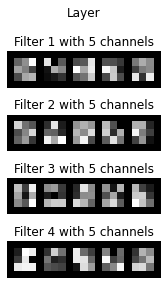

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visChannels(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    plt.figure(figsize=(nrow,rows) )
    plt.title(f"Channels with index {ch}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))


def visFilters(tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.title(f"Filter {filt}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))

def visFilters_subplot(subplot, tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # plt.figure( figsize=(nrow,rows) )
    subplot.set_title(f"Filter {filt+1} with {c} channels")
    subplot.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))
    subplot.axis('off')
    
layer = 1
filter = model.conv2.weight.data.clone()

print(model.conv2.weight.shape)

# need to match the network parameters!!!!
in_channels = 5
out_filters = 4


fig, subplot = plt.subplots(out_filters)
fig.suptitle('Layer')

for filt in range(0, out_filters):
    
    visFilters_subplot(subplot[filt], filter, filt=filt, allkernels=False)

    #plt.axis('off')
    #plt.ioff()
    
plt.tight_layout()
plt.savefig(f"examples/example_results/filter_with_weights.png")
plt.show()
    
if False:    
    for filt in range(0, out_filters):

        visFilters(filter, filt=filt, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.tight_layout()
        #plt.savefig(f"examples/example_results/filter_with_weights.png")
        plt.show()

    for ch in range(0, in_channels):

        visChannels(filter, ch=ch, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

## understand channel importance

## understand filter importance

# 𝔽𝕦𝕟𝕔𝕥𝕚𝕠𝕟 𝕔𝕒𝕝𝕝𝕤

In [ ]:
configs = Configs()

In [ ]:
if configs.run_decentblocks:
    decentblock_routine(configs)

In [ ]:
if configs.run_decentnet:
    decentnet_routine()

In [ ]:
if configs.run_baseline:
    baseline_routine()

In [ ]:
if configs.run_visualisation:
    visualisation_routine()